In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
#EDA Libraries
import pandas_profiling
from pandas_profiling import ProfileReport
#ML PreProcessing
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (Normalizer,MinMaxScaler,RobustScaler,StandardScaler,
                                   OneHotEncoder,OrdinalEncoder,PowerTransformer,QuantileTransformer)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
#Column Transformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
#ML Libraries
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

%matplotlib inline
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
train=pd.read_excel(os.path.join(os.getcwd(),'Train.xlsx'))
run_randomized_search=False

In [3]:
# after a first inspection of the train data excel file, we found out that some columns are the following string: '?' so bellow we check the quantity of '?' string and what columns have them. 
def checkdf_character(df,char): 
    for i in range(len(df.columns)):
        #Printing the column names, number of rows & percentage of rows from the dataset
        #Further details will be printed in the next lines through the utilization of EDA tools
        size=len(df.loc[df.iloc[:,i].astype(str).str.startswith('?')])
        if size>0:
            print('------------------------------------------')
            print('Column: {}{}Number of Rows: {}{}Percentage: {}%'.format(df.columns[i],'\n',size,'\n',round(size/len(df)*100,2)))

In [4]:
#Data inspection shows that the train dataset has rows with question mark '?' character
checkdf_character(train,'?')

------------------------------------------
Column: Base Area
Number of Rows: 395
Percentage: 1.76%
------------------------------------------
Column: Employment Sector
Number of Rows: 1264
Percentage: 5.64%
------------------------------------------
Column: Role
Number of Rows: 1271
Percentage: 5.67%


In [5]:
df=train.copy()
#Get the gender based on the Name title
df.insert(2,'Gender',df['Name'].str.slice(0,4).str.replace('.','').str.replace(' ',''))
df['Gender']=df['Gender'].apply(lambda i: 0 if i=='Mr' else 1)
df['Gender'].unique()

array([0, 1])

In [6]:
df.drop('Name',axis=1,inplace=True)

In [7]:
df.insert(4,'Age',pd.Series([]))
for i,j in enumerate(list(df['Birthday'].values)):
    try:
        df['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ',''),'%B%d,%Y'))/timedelta(days=365.2425))
    except ValueError:
        df['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ','').replace('9','8'),'%B%d,%Y'))/timedelta(days=365.2425))
df['Age']=df['Age'].astype('uint8')

In [8]:
df.drop('Birthday',axis=1,inplace=True)

In [9]:
#As we are using IterativeImputer() to fill the '?' string values we need to change them to NaN's so the algorigthm works.
for i in [6,9,10]:
    aIndex=np.array(df[df.iloc[:,i].astype(str).str.startswith('?')].iloc[:,i].index)
    for j in aIndex:
        df.iloc[j,i]=np.nan
df.isna().sum()

CITIZEN_ID                   0
Gender                       0
Native Continent             0
Age                          0
Marital Status               0
Lives with                   0
Base Area                  395
Education Level              0
Years of Education           0
Employment Sector         1264
Role                      1271
Working Hours per week       0
Money Received               0
Ticket Price                 0
Income                       0
dtype: int64

In [10]:
#Get categorical features
non_metric_col = df.select_dtypes(include=['object']).columns.values

In [11]:
encoder = OrdinalEncoder()
mice = IterativeImputer()

In [12]:
#Function to apply ordinal encoding for train & test dataset
def encode(data,test):
    reshape = np.array(data.dropna()).reshape(-1,1)
    ordinal = encoder.fit(reshape)
    data.loc[data.notnull()] = np.squeeze(ordinal.transform(reshape))
    test.loc[test.notnull()] = np.squeeze(ordinal.transform(np.array(test.dropna()).reshape(-1,1)))

In [19]:
#Backup the dataframe to later apply inverse transform for train & test dataset
df_bkp = df.copy()
for i in non_metric_col: encode(df[i],test[i])

In [20]:
#Refresh dataframe with encoded values
df = pd.DataFrame(np.round(mice.fit_transform(df)),columns=df.columns)
test = pd.DataFrame(np.round(mice.transform(test)),columns=test.columns)
#Filling NaN according to mice algorithm
for i in non_metric_col:
    reshape = np.array(df_bkp[i].dropna()).reshape(-1,1)
    encoder.fit(reshape)
    #Get back the encoded values applying inverse transform based on the train data
    df[i] = encoder.inverse_transform(np.round(df[i].values.reshape(-1,1)))
    test[i] = encoder.inverse_transform(np.round(test[i].values.reshape(-1,1)))
data=df.copy()

In [21]:
#getting phi_k correlation matrix from pandas profiling
def get_phi_k_corr(df,title):
    profile=ProfileReport(df.iloc[:,1:], title=title)
    phi_k=pd.DataFrame([])
    dict=profile.description_set
    for keys,values in dict.items():
            try:
                for keys_ in dict.get(keys).keys():
                    try:
                        if keys_=='phi_k':
                            phi_k= pd.concat([phi_k,dict.get(keys).get(keys_)])
                    except AttributeError as e:
                        pass
            except AttributeError as e:
                pass
    return phi_k

In [22]:
#print correlation matrix
def print_corr_matrix(df,title):
    plt.title(title, size=20)
    mask = np.triu(np.ones_like(df, dtype=np.bool))
    sns.set(rc={'figure.figsize':(15,8)})
    sns.heatmap(df, xticklabels=df.columns, yticklabels=df.columns, annot=True, 
                linewidths=.5, vmin = -1.0, vmax = 1.0, mask = mask,
                cmap=sns.diverging_palette(-10, 240, sep=70, n=7), fmt='.2')
    plt.show()

In [23]:
def classifier_selection(X_train, X_val, y_train, y_val, classifier):
    classifier_score_list=[]
    index_name = ['KNN','LR','NB','RFC','GBC']
    df = pd.DataFrame(index=index_name, columns=['Results'])
    for clsfr in classifier:
        classifier = clsfr
        classifier.fit(X_train, y_train)
        classifier_score = classifier.score(X_val,y_val)
        classifier_score_list.append(classifier_score)
    df['Results'] = classifier_score_list
    return df

In [24]:
def scaler_selection(X_train, X_val, y_train, y_val, model):
    column_name = ['KNN','LR','NB','RFC','GBC']
    df = pd.DataFrame(index=['Normalizer_Test','Robust_Test','MinMax_Test','MinMax_Range_Test','Standard_Test','Power_Transformer_Test','Quantile_Transfomer_Test'],columns=column_name)
    for i,mode in enumerate(model):
        #Normalizer
        transformer = Normalizer()
        transformer.fit(X_train)
        transformer_X_train = transformer.transform(X_train)
        transformer_X_val = transformer.transform(X_val)
        model_baseline_transformer = mode
        model_baseline_transformer.fit(transformer_X_train, y_train)
        transformerf1_val = model_baseline_transformer.score(transformer_X_val,y_val)

        #RobustScaler
        robust_scaler = RobustScaler()
        robust_scaler.fit(X_train)
        robust_X_train = robust_scaler.transform(X_train)
        robust_X_val = robust_scaler.transform(X_val)
        model_baseline_robust = mode
        model_baseline_robust.fit(robust_X_train, y_train)
        robustf1_val = model_baseline_robust.score(robust_X_train,y_train)

        #MinMax
        minmax2 = MinMaxScaler()
        minmax2.fit(X_train)
        min_max_X_train2 = minmax2.transform(X_train)
        min_max_X_val2 = minmax2.transform(X_val)
        min_max_model2 = mode
        min_max_model2.fit(min_max_X_train2, y_train)
        minmaxf1_val2 = min_max_model2.score(min_max_X_val2,y_val)
        
        #MinMax(-1,1)
        minmax = MinMaxScaler(feature_range=(-1,1))
        minmax.fit(X_train)
        min_max_X_train = minmax.transform(X_train)
        min_max_X_val = minmax.transform(X_val)
        min_max_model = mode
        min_max_model.fit(min_max_X_train, y_train)
        minmaxf1_val = min_max_model.score(min_max_X_val,y_val)

        #StandardScaler
        standardscaler = StandardScaler()
        standardscaler.fit(X_train)
        standardscaler_X_train = standardscaler.transform(X_train)
        standardscaler_X_val = standardscaler.transform(X_val)
        standardscaler_model = mode
        standardscaler_model.fit(standardscaler_X_train, y_train)
        standard_f1_val = standardscaler_model.score(standardscaler_X_val,y_val)
                
        #PowerTransfomer
        powertransformer = PowerTransformer(method='yeo-johnson')
        powertransformer.fit(X_train)
        powertransformer_X_train = powertransformer.transform(X_train)
        powertransformer_X_val = powertransformer.transform(X_val)
        powertransformer_model = mode
        powertransformer_model.fit(powertransformer_X_train, y_train)
        powertransformer_f1_val = powertransformer_model.score(powertransformer_X_val,y_val)
        
        #QuantileTransfomer
        quantiletransfomer = QuantileTransformer(n_quantiles=500, output_distribution='normal', random_state=5)
        quantiletransfomer.fit(X_train)
        quantiletransfomer_X_train = quantiletransfomer.transform(X_train)
        quantiletransfomer_X_val = quantiletransfomer.transform(X_val)
        quantiletransfomer_model = mode
        quantiletransfomer_model.fit(quantiletransfomer_X_train, y_train)
        quantiletransfomer_f1_val = quantiletransfomer_model.score(quantiletransfomer_X_val,y_val)
  
        #Summary
        df[column_name[i]][0] = transformerf1_val
        df[column_name[i]][1] = robustf1_val
        df[column_name[i]][2] = minmaxf1_val     
        df[column_name[i]][3] = minmaxf1_val2
        df[column_name[i]][4] = standard_f1_val
        df[column_name[i]][5] = powertransformer_f1_val
        df[column_name[i]][6] = quantiletransfomer_f1_val
    return df

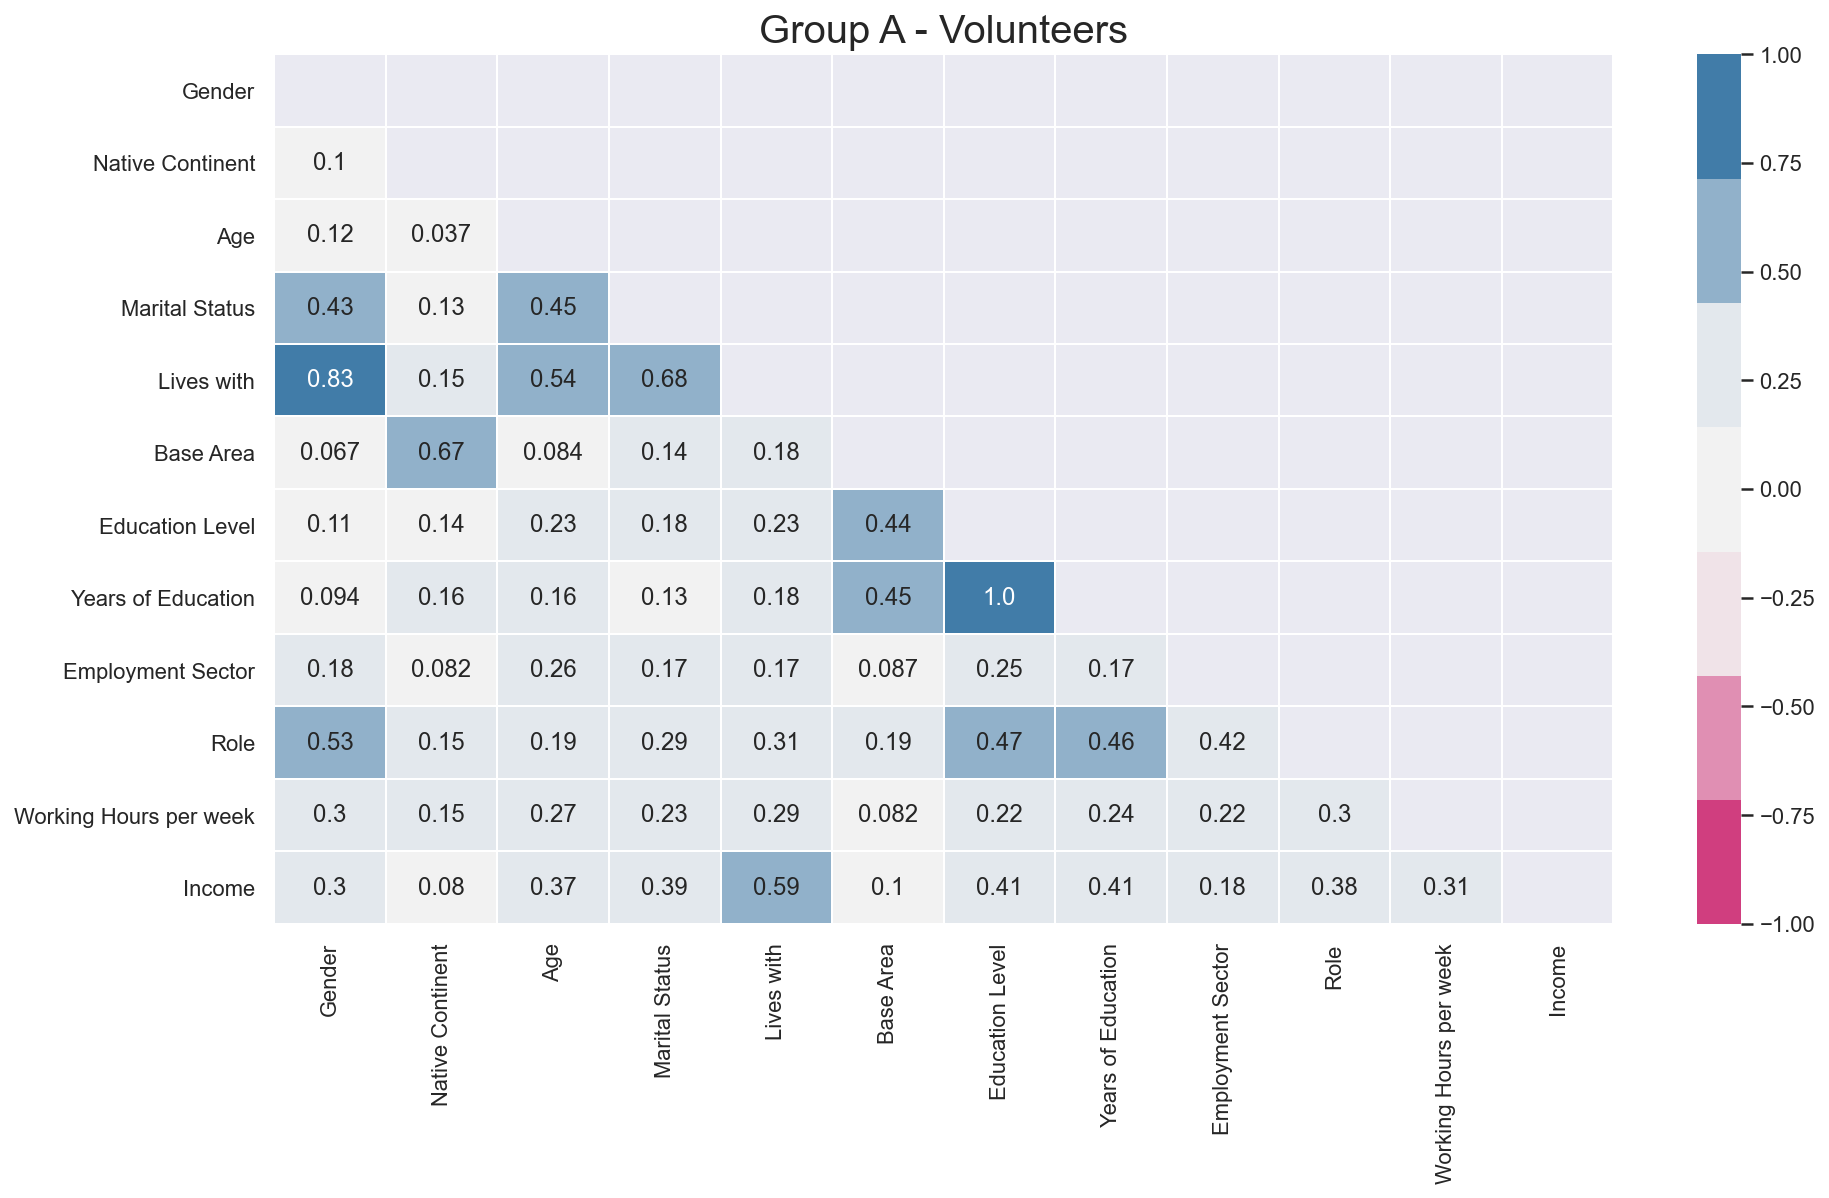

Income                    1.000000
Lives with                0.586095
Education Level           0.411534
Years of Education        0.408981
Marital Status            0.390183
Role                      0.377633
Age                       0.370947
Working Hours per week    0.308169
Gender                    0.302077
Employment Sector         0.179437
Base Area                 0.100856
Native Continent          0.080031
Name: Income, dtype: float64

In [26]:
#Group A: Volunteers
data_a=data[(data['Ticket Price']==0) & (data['Money Received']==0)].copy()
data_a.reset_index(inplace=True)
data_a.drop(data_a.columns[0],axis=1,inplace=True)
#Get correlation matrix
phi_k_a=get_phi_k_corr(data_a,'')
#Print matrix
print_corr_matrix(phi_k_a,'Group A - Volunteers')
phi_k_a.loc[:,'Income'].sort_values(ascending=False)

In [27]:
data_b1=data[data['Money Received']>=122999].copy()

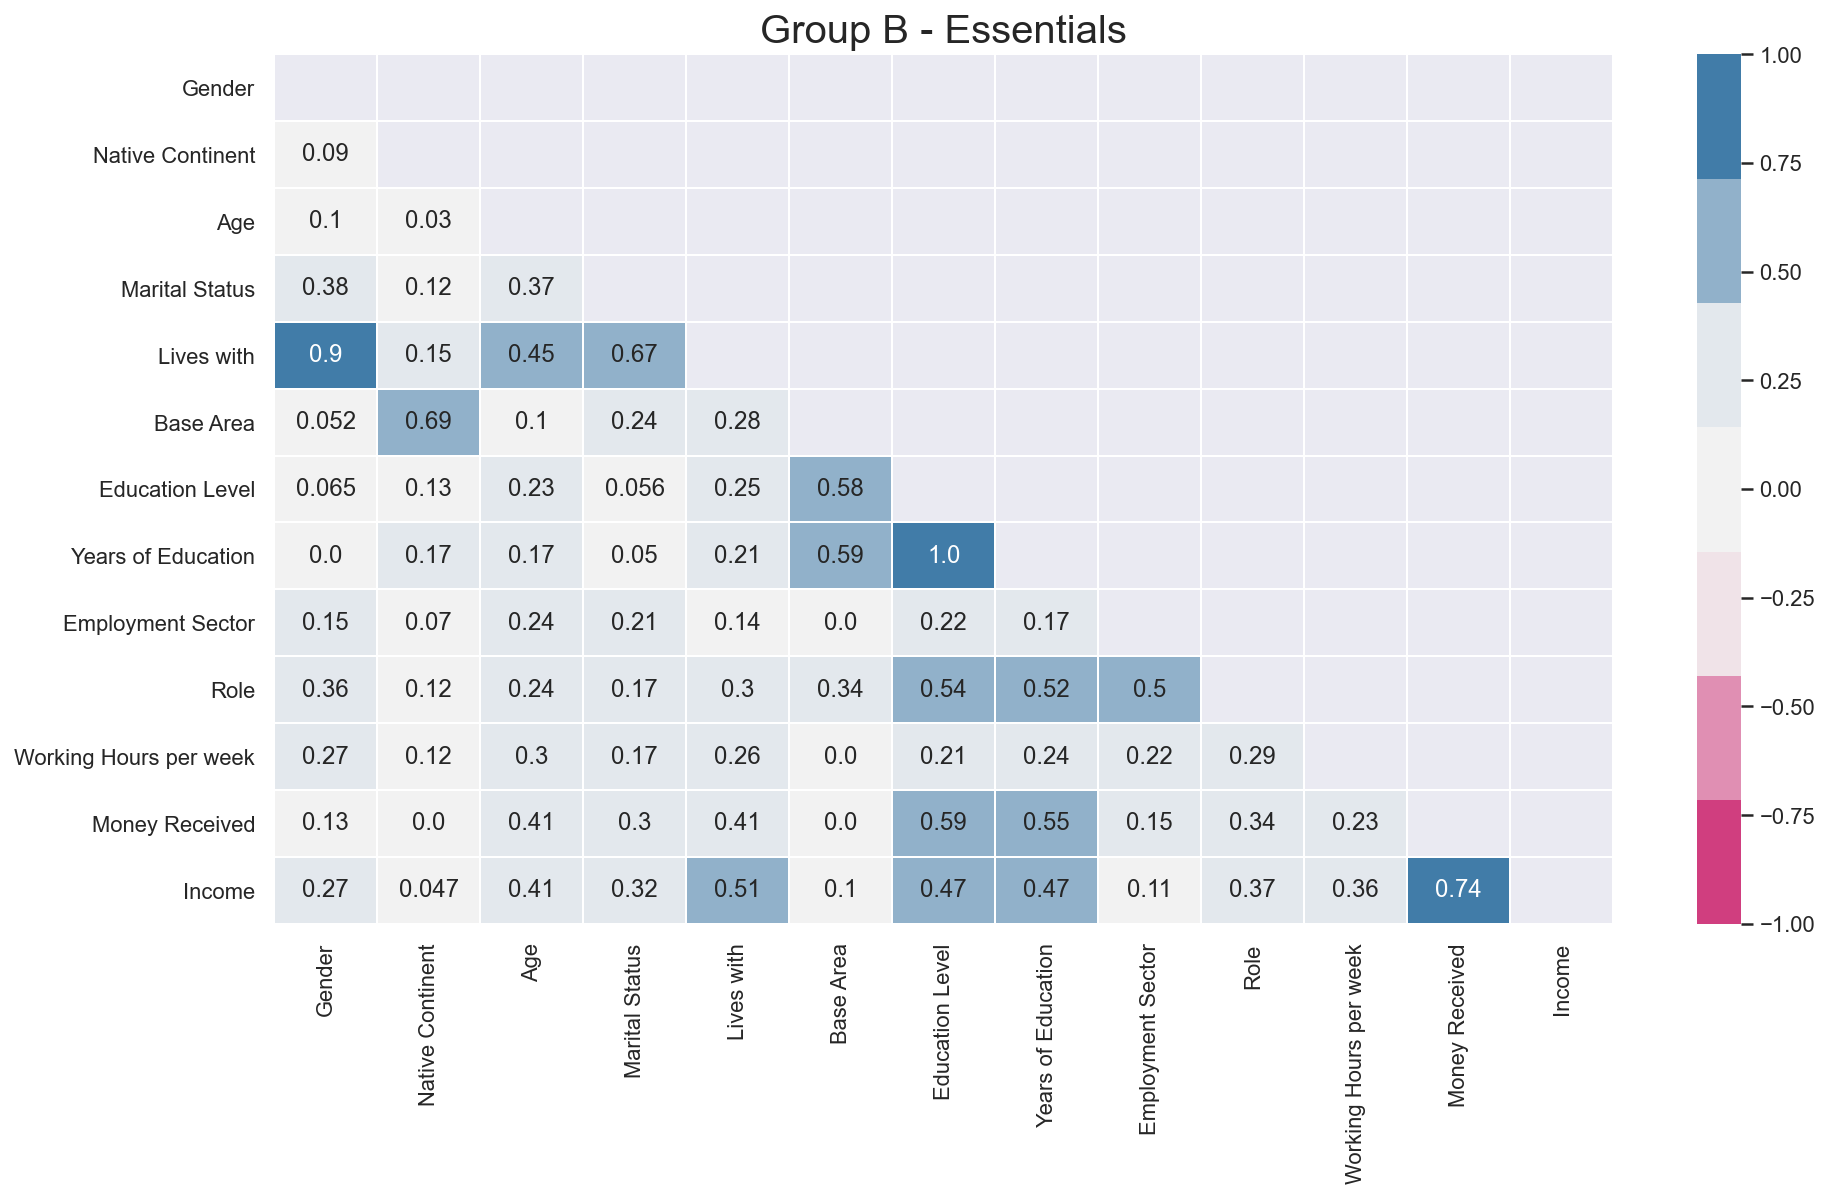

Income                    1.000000
Money Received            0.740334
Lives with                0.511066
Years of Education        0.474614
Education Level           0.472060
Age                       0.406530
Role                      0.373668
Working Hours per week    0.355319
Marital Status            0.316783
Gender                    0.272078
Employment Sector         0.108435
Base Area                 0.099855
Native Continent          0.046609
Name: Income, dtype: float64

In [28]:
#Group B: Essentials
data_b=data[(data['Money Received']>0) & (data['Money Received']<122999)].copy()
data_b.reset_index(inplace=True)
data_b.drop(data_b.columns[0],axis=1,inplace=True)
#Get correlation matrix
phi_k_b=get_phi_k_corr(data_b,'')
#Print matrix
print_corr_matrix(phi_k_b,'Group B - Essentials')
phi_k_b.loc[:,'Income'].sort_values(ascending=False)

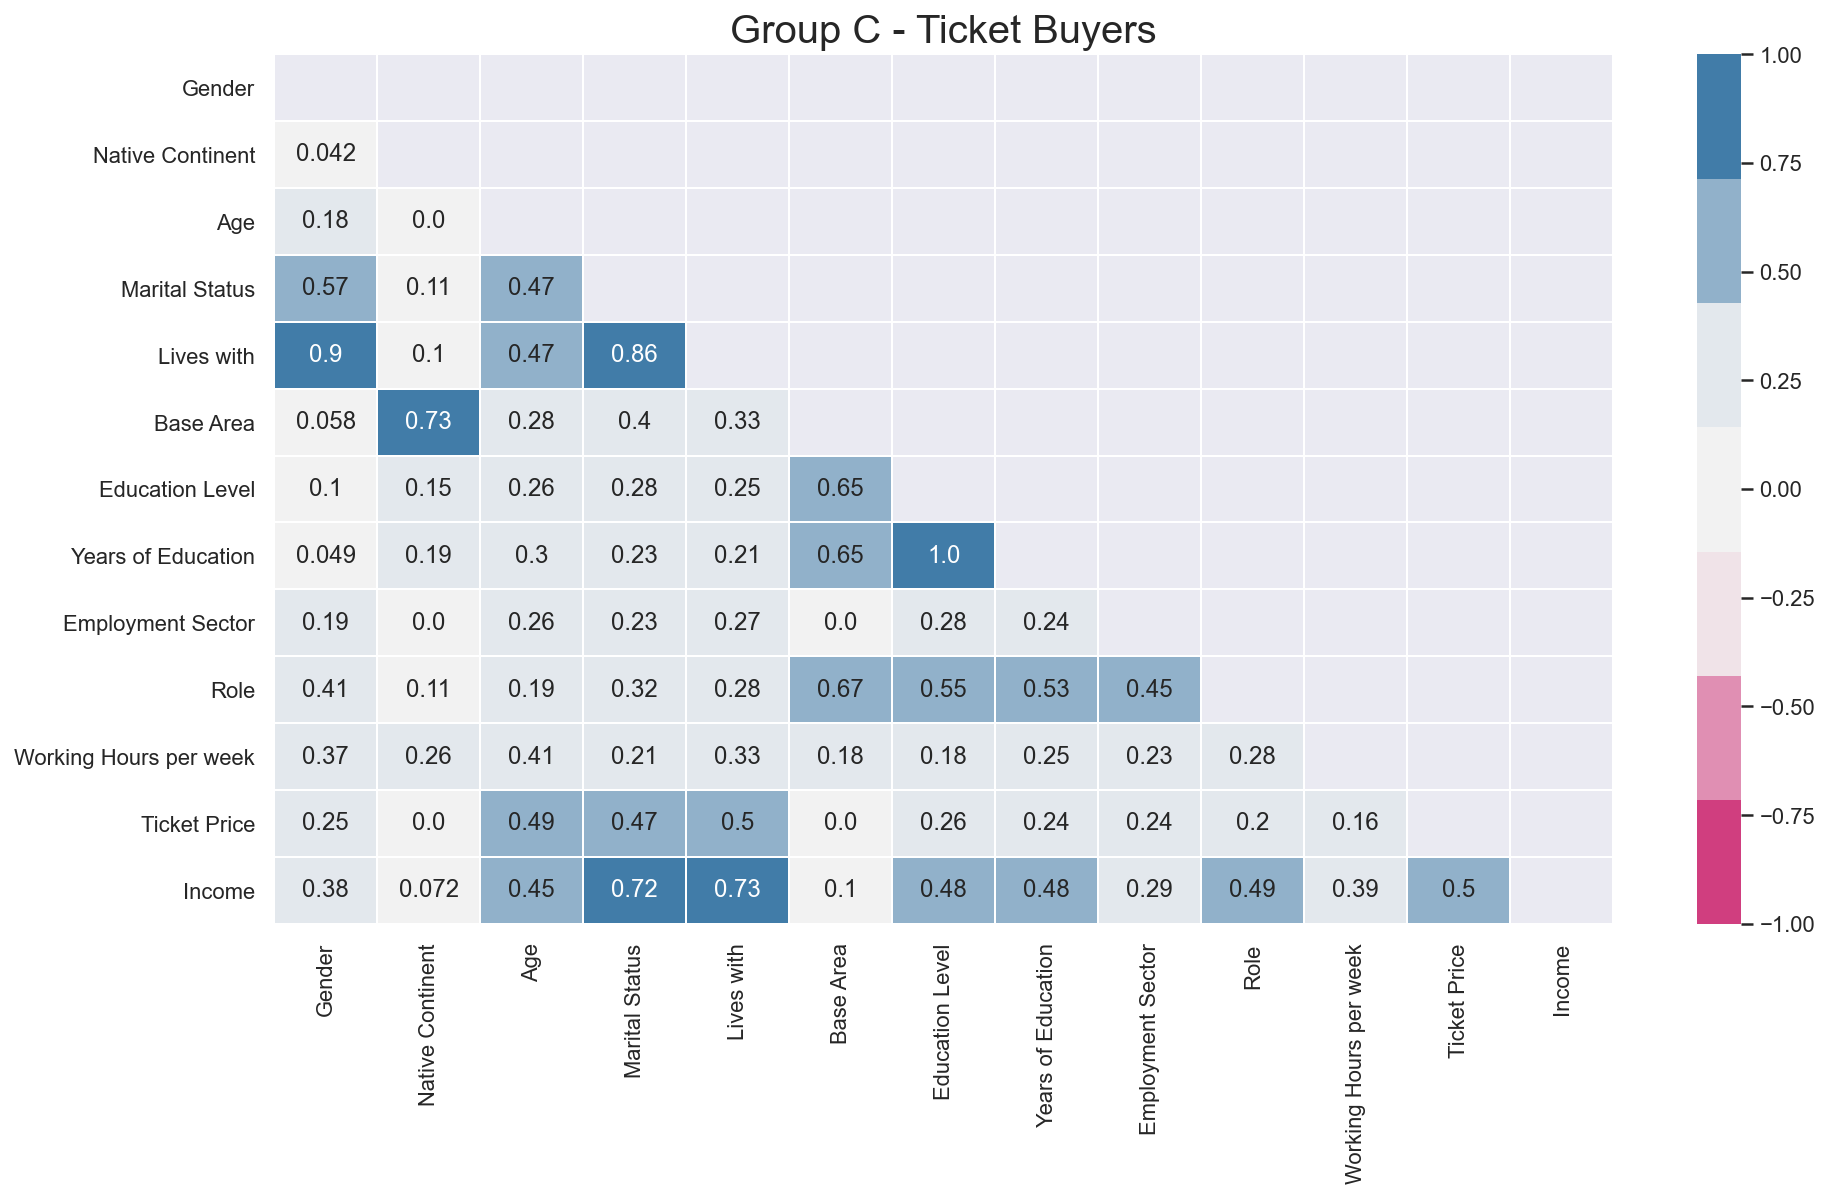

Income                    1.000000
Lives with                0.732715
Marital Status            0.722570
Ticket Price              0.501141
Role                      0.488935
Years of Education        0.482735
Education Level           0.479631
Age                       0.453034
Working Hours per week    0.385629
Gender                    0.376127
Employment Sector         0.286403
Base Area                 0.099534
Native Continent          0.071752
Name: Income, dtype: float64

In [29]:
#Group C: Buy Entry -> Ticket Price
data_c=data[data['Ticket Price']>0].copy()
data_c.reset_index(inplace=True)
data_c.drop(data_c.columns[0],axis=1,inplace=True)
#Get correlation matrix
phi_k_c=get_phi_k_corr(data_c,'')
#Print matrix
print_corr_matrix(phi_k_c,'Group C - Ticket Buyers')
phi_k_c.loc[:,'Income'].sort_values(ascending=False)

In [30]:
print('Volunteers: {}\nHigh Earners: {}\nEssentials: {}\nTicket Buyers: {}'.format(len(data_a),len(data_b1),len(data_b),len(data_c)))

Volunteers: 19511
High Earners: 114
Essentials: 1718
Ticket Buyers: 1057


In [31]:
data_a.set_index('CITIZEN_ID',inplace=True)
data_b.set_index('CITIZEN_ID',inplace=True)
data_c.set_index('CITIZEN_ID',inplace=True)

In [32]:
def onehot_categorical(df):
    return make_column_transformer((OneHotEncoder(handle_unknown='ignore'),df.select_dtypes(include='object').columns.values),remainder='passthrough')

In [33]:
#Group A
column_a=[0,2,3,4,6,9,10] #getting the features from phik
transf_a=onehot_categorical(data_a.iloc[:,column_a])
upd_a=pd.DataFrame(transf_a.fit_transform(data_a.iloc[:,column_a]).toarray(),columns=transf_a.get_feature_names())

In [34]:
#Split Dataset A
X_train_a, X_val_a, y_train_a, y_val_a = train_test_split(upd_a, data_a.iloc[:,-1], test_size=0.3, random_state=5, 
                                                  stratify=data_a.iloc[:,-1])

In [35]:
classifier_selection(X_train_a, X_val_a, y_train_a, y_val_a,[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),RandomForestClassifier(random_state=5),GradientBoostingClassifier()])

,Results
KNN,0.820635
LR,0.857704
NB,0.600957
RFC,0.830714
GBC,0.861291


In [36]:
scaler_selection(X_train_a, X_val_a, y_train_a, y_val_a,[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),RandomForestClassifier(),GradientBoostingClassifier()])

,KNN,LR,NB,RFC,GBC
Normalizer_Test,0.829347,0.812948,0.611718,0.838401,0.857533
Robust_Test,0.880135,0.851578,0.561251,0.962583,0.858095
MinMax_Test,0.834985,0.857704,0.543731,0.830543,0.861291
MinMax_Range_Test,0.834814,0.858387,0.543731,0.833447,0.861121
Standard_Test,0.838914,0.857362,0.522549,0.83191,0.861291
Power_Transformer_Test,0.838743,0.857875,0.522207,0.828664,0.861121
Quantile_Transfomer_Test,0.834301,0.85685,0.543389,0.833618,0.861121


In [37]:
#Group B
transf_b=onehot_categorical(data_b.iloc[:,:-1])
upd_b=pd.DataFrame(transf_b.fit_transform(data_b.iloc[:,:-1]).toarray(),columns=transf_b.get_feature_names())

In [38]:
#Split Dataset B
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(upd_b, data_b.iloc[:,-1], test_size=0.3, random_state=5, 
                                                  stratify=data_b.iloc[:,-1])

In [39]:
classifier_selection(X_train_b, X_val_b, y_train_b, y_val_b,[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),RandomForestClassifier(),GradientBoostingClassifier()])

,Results
KNN,0.982558
LR,0.844961
NB,0.765504
RFC,0.922481
GBC,0.970930


In [40]:
scaler_selection(X_train_b, X_val_b, y_train_b, y_val_b, [KNeighborsClassifier(),LogisticRegression(),GaussianNB(),RandomForestClassifier(),GradientBoostingClassifier()])

,KNN,LR,NB,RFC,GBC
Normalizer_Test,0.831395,0.587209,0.763566,0.959302,0.96124
Robust_Test,0.891847,0.899334,0.684692,1,0.993344
MinMax_Test,0.763566,0.844961,0.653101,0.928295,0.97093
MinMax_Range_Test,0.763566,0.80814,0.653101,0.905039,0.97093
Standard_Test,0.753876,0.848837,0.633721,0.924419,0.97093
Power_Transformer_Test,0.753876,0.843023,0.635659,0.920543,0.97093
Quantile_Transfomer_Test,0.757752,0.844961,0.651163,0.926357,0.97093


In [41]:
#Group C
column_c=[2,4,6,9,12] #getting features from phik
transf_c=onehot_categorical(data_c.iloc[:,column_c])
upd_c=pd.DataFrame(transf_c.fit_transform(data_c.iloc[:,column_c]).toarray(),columns=transf_c.get_feature_names())

In [42]:
#Split Dataset C
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(upd_c, data_c.iloc[:,-1], test_size=0.3, random_state=5, 
                                                  stratify=data_c.iloc[:,-1])

In [43]:
classifier_selection(X_train_c, X_val_c, y_train_c, y_val_c,[KNeighborsClassifier(),LogisticRegression(),GaussianNB(),RandomForestClassifier(),GradientBoostingClassifier()])

,Results
KNN,0.927673
LR,0.764151
NB,0.710692
RFC,0.918239
GBC,0.924528


In [44]:
scaler_selection(X_train_c, X_val_c, y_train_c, y_val_c, [KNeighborsClassifier(),LogisticRegression(),GaussianNB(),RandomForestClassifier(),GradientBoostingClassifier()])

,KNN,LR,NB,RFC,GBC
Normalizer_Test,0.716981,0.509434,0.663522,0.908805,0.915094
Robust_Test,0.889039,0.830853,0.631935,1,0.986468
MinMax_Test,0.773585,0.77044,0.622642,0.918239,0.924528
MinMax_Range_Test,0.773585,0.757862,0.622642,0.893082,0.924528
Standard_Test,0.748428,0.786164,0.616352,0.908805,0.924528
Power_Transformer_Test,0.745283,0.786164,0.616352,0.902516,0.924528
Quantile_Transfomer_Test,0.808176,0.773585,0.619497,0.915094,0.924528


In [45]:
def apply_scaling(df, scaling):
    scaler = scaling().fit(df)
    df_train = scaler.transform(df)
    return scaler, df_train

In [46]:
scaler_a, X_train_s_a = apply_scaling(upd_a, RobustScaler)
scaler_b, X_train_s_b = apply_scaling(upd_b, RobustScaler)
scaler_c, X_train_s_c = apply_scaling(upd_c, RobustScaler)

In [56]:
#Split Dataset A
X_train_na, X_val_na, y_train_na, y_val_na = train_test_split(X_train_s_a, data_a.iloc[:,-1], test_size=0.3, random_state=5, 
                                                  stratify=data_a.iloc[:,-1])

In [48]:
if run_randomized_search:
    #Set GBC search parameters
    n_estimators=list(range(100, 1600, 100))
    learning_rate=[0.0001,0.001,0.01]
    #Create a dictionary with the search parameters
    param = dict(n_estimators=n_estimators, learning_rate=learning_rate)
    #Perform randomized search
    rsearch_a = RandomizedSearchCV(GradientBoostingClassifier(), param, cv=10, scoring='accuracy', n_iter=200, random_state=5, n_jobs=-1)
    rsearch_a.fit(X_train_na, y_train_na)
    #Examine the best parameters
    print(rsearch_a.best_score_)
    print(rsearch_a.best_params_)

In [57]:
pipe_a=make_pipeline(GradientBoostingClassifier(n_estimators=1200, learning_rate=0.01, random_state=5))

In [58]:
cross_val_score(pipe_a, X_train_na, y_train_na, cv=5, scoring='accuracy').mean()

0.8518707181200822

In [59]:
pipe_a.fit(X_train_na, y_train_na)
y_pred_a=pipe_a.predict(X_val_na)
print(confusion_matrix(y_val_na, y_pred_a))
print(f1_score(y_val_na, y_pred_a ,average='micro'))

[[4523  236]
 [ 573  522]]
0.861803894772805


In [66]:
#Split Dataset B
X_train_nb, X_val_nb, y_train_nb, y_val_nb = train_test_split(X_train_s_b, data_b.iloc[:,-1], test_size=0.3, random_state=1, 
                                                  stratify=data_b.iloc[:,-1])

In [67]:
pipe_b=make_pipeline(GradientBoostingClassifier(n_estimators=1200, learning_rate=0.01, random_state=1))

In [68]:
cross_val_score(pipe_b, X_train_nb, y_train_nb, cv=5, scoring='accuracy').mean()

0.975878284923928

In [69]:
pipe_b.fit(X_train_nb, y_train_nb)
y_pred_b=pipe_b.predict(X_val_nb)
print(confusion_matrix(y_val_nb, y_pred_b))
print(f1_score(y_val_nb, y_pred_b ,average='micro'))

[[212   2]
 [  1 301]]
0.9941860465116279


In [72]:
#Split Dataset C
X_train_nc, X_val_nc, y_train_nc, y_val_nc = train_test_split(X_train_s_c, data_c.iloc[:,-1], test_size=0.3, random_state=1, 
                                                  stratify=data_c.iloc[:,-1])

In [73]:
pipe_c=make_pipeline(GradientBoostingClassifier(n_estimators=1200, learning_rate=0.01, random_state=1))

In [74]:
cross_val_score(pipe_c, X_train_nc, y_train_nc, cv=5, scoring='accuracy').mean()

0.9242599742599742

In [75]:
pipe_c.fit(X_train_nc, y_train_nc)
y_pred_c=pipe_c.predict(X_val_nc)
print(confusion_matrix(y_val_nc, y_pred_c))
print(f1_score(y_val_nc, y_pred_c ,average='micro'))

[[145  11]
 [  5 157]]
0.949685534591195


In [78]:
#Creating a final dataframe with predicted & validation values
#Group A -> Volunteers
data_ap=pd.DataFrame(y_val_na,columns=['Income'])
data_ap['Income_P']=pd.Series(y_pred_a,index=data_ap.index)
#Group B -> High Earners
data_bp1=data_b1.loc[:,['CITIZEN_ID','Income']].set_index('CITIZEN_ID')
data_bp1['Income_P']=data_bp1['Income']
#Group B -> Essentials
data_bp=pd.DataFrame(y_val_nb,columns=['Income'])
data_bp['Income_P']=pd.Series(y_pred_b,index=data_bp.index)
#Group C -> Ticket Buyers
data_cp=pd.DataFrame(y_val_nc,columns=['Income'])
data_cp['Income_P']=pd.Series(y_pred_c,index=data_cp.index)
#Concat dataframes
data_pred=pd.concat([data_ap.reset_index(),data_bp1.reset_index(),data_bp.reset_index(),data_cp.reset_index()]).set_index('CITIZEN_ID')

In [79]:
print(confusion_matrix(data_pred.iloc[:,0], data_pred.iloc[:,1]))
print(f1_score(data_pred.iloc[:,0], data_pred.iloc[:,1] ,average='micro'))

[[4880  249]
 [ 579 1094]]
0.878271096736254


# Prediction Preparation

In [13]:
test_bkp=pd.read_excel(os.path.join(os.getcwd(),'Test.xlsx'))
test=test_bkp.copy()

In [14]:
test.insert(2,'Gender',test['Name'].str.slice(0,4).str.replace('.','').str.replace(' ',''))
test['Gender']=test['Gender'].apply(lambda i: 0 if i=='Mr' else 1)
test['Gender'].unique()

array([0, 1])

In [15]:
test.drop('Name',axis=1,inplace=True)

In [16]:
test.insert(4,'Age',pd.Series([]))
for i,j in enumerate(list(test['Birthday'].values)):
    try:
        test['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ',''),'%B%d,%Y'))/timedelta(days=365.2425))
    except ValueError:
        test['Age'][i]=np.round((datetime.now()+timedelta(days=10228)-datetime.strptime(j.replace(' ','').replace('9','8'),'%B%d,%Y'))/timedelta(days=365.2425))
test['Age']=test['Age'].astype('uint8')

In [17]:
test.drop('Birthday',axis=1,inplace=True)
test['Income']=0

In [18]:
# since we are using IterativeImputer() to fill the '?' string values we need to change them to NaN's so the algorigthm works.
for i in [6,9,10]:
    aIndex=np.array(test[test.iloc[:,i].astype(str).str.startswith('?')].iloc[:,i].index)
    for j in aIndex:
        test.iloc[j,i]=np.nan
test.isna().sum()

CITIZEN_ID                  0
Gender                      0
Native Continent            0
Age                         0
Marital Status              0
Lives with                  0
Base Area                 187
Education Level             0
Years of Education          0
Employment Sector         570
Role                      570
Working Hours per week      0
Money Received              0
Ticket Price                0
Income                      0
dtype: int64

In [60]:
#Group A: Volunteers
test_a=test[(test['Ticket Price']==0) & (test['Money Received']==0)].copy()
test_a.reset_index(inplace=True)
test_a.drop(test_a.columns[0],axis=1,inplace=True)
test_a.set_index('CITIZEN_ID',inplace=True)
test_a=test_a.iloc[:,column_a]

In [61]:
#Group B1: High Earners having an income already known
test_b1=test[test['Money Received']>=122999].copy()
test_b1['Income']=1
test_b1.set_index('CITIZEN_ID',inplace=True)

In [62]:
#Group B: Essentials
test_b=test[(test['Money Received']>0) & (test['Money Received']<122999)].copy()
test_b.reset_index(inplace=True)
test_b.drop(test_b.columns[0],axis=1,inplace=True)
test_b.set_index('CITIZEN_ID',inplace=True)

In [63]:
#Group C: Buy Entry -> Ticket Price
test_c=test[test['Ticket Price']>0].copy()
test_c.reset_index(inplace=True)
test_c.drop(test_c.columns[0],axis=1,inplace=True)
test_c.set_index('CITIZEN_ID',inplace=True)
test_c=test_c.iloc[:,column_c]

In [64]:
#Scaling Group A
test_scaler_a=scaler_a.transform(pd.DataFrame(transf_a.transform(test_a).toarray(),columns=transf_a.get_feature_names()))

In [65]:
#Predicting Group A
test_a['Income']=pipe_a.predict(test_scaler_a)

In [70]:
#Scaling Group B
test_scaler_b=scaler_b.transform(pd.DataFrame(transf_b.transform(test_b.iloc[:,:-1]).toarray(),columns=transf_b.get_feature_names()))

In [71]:
test_b['Income']=pipe_b.predict(test_scaler_b)

In [76]:
#Scaling Group C
test_scaler_c=scaler_c.transform(pd.DataFrame(transf_c.transform(test_c).toarray(),columns=transf_c.get_feature_names()))

In [77]:
test_c['Income']=pipe_c.predict(test_scaler_c)

In [80]:
test_pred=pd.concat([test_a['Income'].reset_index(),test_b1['Income'].reset_index(),test_b['Income'].reset_index(),test_c['Income'].reset_index()],axis=0).copy()

In [81]:
test_pred['CITIZEN_ID']=test_pred['CITIZEN_ID'].astype(int)
test_pred.set_index('CITIZEN_ID',inplace=True)

In [82]:
pd.options.display.float_format = '{:,.0f}'.format
test_pred['Income']=test_pred['Income'].astype(float)
test_pred['Income']=test_pred['Income'].astype(int)
test_pred['Income']=test_pred['Income'].astype('string')
test_pred.sort_index(inplace=True)

In [83]:
test_pred.to_csv('result_1.csv')